In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q umap-learn
import umap
import numpy as np


import random
import tensorflow as tf

from tensorflow.keras.datasets import mnist
 
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG
from matplotlib import pyplot as plt
import math
import plotly.express as px

     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 1.2MB 18.8MB/s 


In [66]:
num_classes = 10
epochs = 50
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [70]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels).astype(np.float32)



# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) =   cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)


## visualize pairs


In [85]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def create_base_conv_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    # x = Flatten()(input)
    x = Conv2D(32, (3, 3), activation='relu', name="conv1")(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', name="conv2")(x)
    x = MaxPooling2D((2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', name="conv3")(x)
    # x = MaxPooling2D((1, 1))(x)
    x = Conv2D(64, (3, 3), activation='relu', name="conv4")(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name="dense128")(x)
    # x = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1))(x)
    # x = Lambda(lambda  x: tf.math.l2_normaliz(x,axis=1))(x)
    # x = Dropout(0.1)(x) 
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


def plot_history(history):

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
   
  # Plot training & validation accuracy values
  axes[0].plot(history.history['accuracy'])
  axes[0].plot(history.history['val_accuracy'])
  axes[0].title.set_text('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  # plt.show()

  # Plot training & validation loss values
  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].title.set_text('Model Losss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  fig.tight_layout()
  plt.show()

def plot_features(model, title="UMAP Embedding Projection"):
  test_features = model(x_test)
  print("Compute UMAP for vector with shape", test_features.shape)
  reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="euclidean")
  embedding = reducer.fit_transform(test_features)

  colors = [ x[0] for x in y_test] 
  acm = [class_names[x] for x in colors]

  fig = px.scatter(
      x=embedding[:, 0],
      y=embedding[:, 1],
      color=acm,
      hover_name=acm,
      # symbol=acm,
      width=1200,
      height=900,
      title=title,
  )
  fig.show()  

In [86]:
classsification_base_network = create_base_conv_network(input_shape) 
x = classsification_base_network.get_layer("dense128").output
x = Dense(10, activation='relu', name="dense10")(x)
classification_model = Model(
    inputs=classsification_base_network.input, outputs=x, name="classification_model"
)

classification_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# SVG(model_to_dot(classification_model, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))
classification_model.summary()

Model: "classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_16 (Flatten)         (None, 1024)     

In [87]:
classification_history = classification_model.fit(x_train, y_train, 
                                                  batch_size=128, epochs=epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/50
391/391 [==============================] - 3s 6ms/step - loss: 2.0412 - accuracy: 0.2893 - val_loss: 1.7740 - val_accuracy: 0.4140
Epoch 2/50
391/391 [==============================] - 2s 5ms/step - loss: 1.7492 - accuracy: 0.4197 - val_loss: 1.6603 - val_accuracy: 0.4525
Epoch 3/50
391/391 [==============================] - 2s 5ms/step - loss: 1.6283 - accuracy: 0.4575 - val_loss: 1.6337 - val_accuracy: 0.4571
Epoch 4/50
391/391 [==============================] - 2s 5ms/step - loss: 1.5690 - accuracy: 0.4751 - val_loss: 1.5480 - val_accuracy: 0.4863
Epoch 5/50
391/391 [==============================] - 2s 5ms/step - loss: 1.4738 - accuracy: 0.5011 - val_loss: 1.5555 - val_accuracy: 0.4728
Epoch 6/50
391/391 [==============================] - 2s 5ms/step - loss: 1.4424 - accuracy: 0.5067 - val_loss: 1.5106 - val_accuracy: 0.4936
Epoch 7/50
391/391 [==============================] - 2s 5ms/step - loss: 1.4078 - accuracy: 0.5119 - val_loss: 1.4851 - val_accuracy: 0.4956
Epoch 

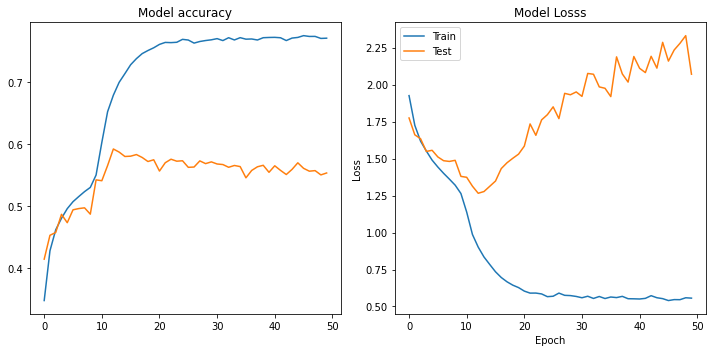

In [88]:
plot_history(classification_history)

In [89]:
plot_features(classsification_base_network, title="UMAP Embedding Projection CIFAR10 - Classification Model")

Compute UMAP for vector with shape (10000, 512)


In [96]:
# network definition
siamese_base_network = create_base_conv_network(input_shape)
x = siamese_base_network.get_layer("dense128").output
x = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), name="normalize1")(x)
x = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), name="normalize2")(x) 
siamese_base_network = Model(
    inputs=siamese_base_network.input, outputs=x, name="classification_model"
)



input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = siamese_base_network(input_a)
processed_b = siamese_base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

siamese_model = Model([input_a, input_b], distance)
siamese_base_network.summary()
# SVG(model_to_dot(base_network, show_layer_names=True, show_shapes=True, dpi=50).create(prog='dot', format='svg'))
# SVG(model_to_dot(siamese_model, show_layer_names=True, show_shapes=True, dpi=50).create(prog='dot', format='svg'))

Model: "classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_21 (Flatten)         (None, 1024)     

In [97]:
# train
siamese_model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])


In [ ]:
siamese_history = siamese_model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/50
782/782 [==============================] - 8s 9ms/step - loss: 0.2207 - accuracy: 0.6359 - val_loss: 0.1876 - val_accuracy: 0.7149
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1862 - accuracy: 0.7158 - val_loss: 0.1778 - val_accuracy: 0.7353
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1709 - accuracy: 0.7487 - val_loss: 0.1700 - val_accuracy: 0.7479
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1583 - accuracy: 0.7718 - val_loss: 0.1594 - val_accuracy: 0.7695
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1498 - accuracy: 0.7889 - val_loss: 0.1561 - val_accuracy: 0.7779
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1405 - accuracy: 0.8061 - val_loss: 0.1583 - val_accuracy: 0.7692
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1348 - accuracy: 0.8176 - val_loss: 0.1552 - val_accuracy: 0.7776
Epoch 

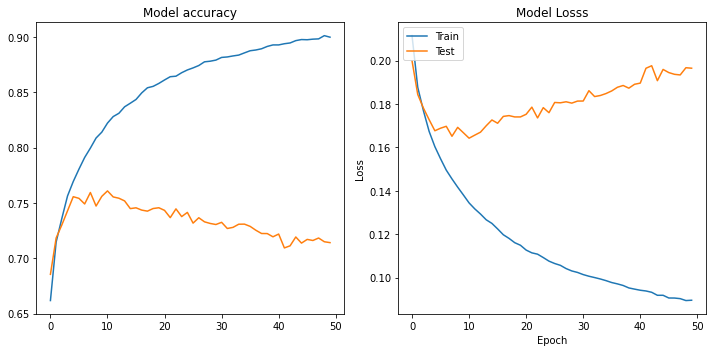

In [46]:
plot_history(siamese_history)

In [50]:
plot_features(siamese_base_network, title="UMAP Embedding Projection CIFAR10 - Siamese Model")

Compute UMAP for vector with shape (10000, 256)


In [63]:
siamese_base_network.save('models/siamese_base.h5')
classsification_base_network.save('models/classification_base.h5') 

siamese_model.save("models/siamese.h5")
classification_model.save('models/classification.h5') 

In [64]:
model_basepath="/content/drive/MyDrive/mlexperiments/siamese/"

In [65]:
!cp -r models $model_basepath 

In [ ]:
from tensorflow import keras
siamese_base_network = keras.models.load_model(model_basepath +'models/siamese_base.h5')
classsification_base_network = keras.models.load_model(model_basepath +'models/classification_base.h5')